# Major Project: Living Thing Classification

Nottachat Kaewgard

Student ID: 47369833

Kaggle: melnottachat

# Introduction

This notebook is for the major project submission for COMP8220, on the living things dataset and task.  It contains the following sections:

*   a description of the selected conventional ML model;
*   some notes about the choices made in building the conventional ML model;
*   a description of the selected deep learning model;
*   some notes about the choices made in building the deep model; and
*   a discussion of the performance of the two models.



# Preparation

## Setup Environment

In [1]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier  
import xgboost
import lightgbm

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import seaborn as sns
import matplotlib.pyplot as plt

from functools import partial

import warnings
warnings.filterwarnings('ignore')

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tf.keras.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

2023-06-03 13:29:29.555318: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Tensor Flow Version: 2.10.0
Keras Version: 2.10.0
GPU is NOT AVAILABLE


In [ ]:
batch_size = 64
img_size = 112
fine_grain = False
num_classes = 50 if fine_grain else 8

root = Path('public')

In [ ]:
def load_target_names(path='public/info.json'):
    with open(path) as f:
        info = json.load(f)
    return info['fine'], info['coarse']

def load_image(file_path, image_size=112):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [image_size, image_size])
    return img

def create_dataset_tf(split, fine_grained, batch_size=32, image_size=112):
  df = pd.read_csv(root / f"{split}.csv")
  file_paths = df.filename.map(lambda fn: str(root / split / fn))
  labels = df.fine if fine_grained else df.coarse

  dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
  dataset = dataset.map(lambda x, y: (load_image(x, image_size=image_size), y))
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
  return dataset


def create_dataset_sklearn(split, fine_grained, image_size=48, percent=0.1):
  dataset = create_dataset_tf(split=split, fine_grained=fine_grained, batch_size=1000, image_size=image_size)
  dataset = dataset.map(lambda x, y: (tf.image.rgb_to_grayscale(x), y))
  X = None
  Y = None
  n_batches = int(len(dataset) * percent)
  for x,y in dataset.take(n_batches):
    x, y = x.numpy(), y.numpy()
    x = x.reshape(x.shape[0], -1)
    X = x if X is None else np.vstack([X, x])
    Y = y if Y is None else np.hstack([Y, y])

  return X, Y

## Import Data

In [ ]:
fine_names, coarse_names = load_target_names()
print(coarse_names)

['Aves', 'Reptilia', 'Mammalia', 'Arachnida', 'Magnoliopsida', 'Insecta', 'Liliopsida', 'Pinopsida']


In [ ]:
print(fine_names)

['Scolopacidae', 'Laridae', 'Accipitridae', 'Anatidae', 'Corvidae', 'Icteridae', 'Picidae', 'Colubridae', 'Sciuridae', 'Rosaceae', 'Cyperaceae', 'Brassicaceae', 'Sphingidae', 'Orchidaceae', 'Apidae', 'Papilionidae', 'Orobanchaceae', 'Liliaceae', 'Apocynaceae', 'Poaceae', 'Araneidae', 'Pinaceae', 'Asparagaceae', 'Acrididae', 'Hesperiidae', 'Rubiaceae', 'Onagraceae', 'Libellulidae', 'Fagaceae', 'Cactaceae', 'Lycaenidae', 'Coenagrionidae', 'Boraginaceae', 'Ranunculaceae', 'Polygonaceae', 'Pieridae', 'Caryophyllaceae', 'Lamiaceae', 'Noctuidae', 'Apiaceae', 'Malvaceae', 'Geometridae', 'Plantaginaceae', 'Euphorbiaceae', 'Crambidae', 'Parulidae', 'Erebidae', 'Ericaceae', 'Passerellidae', 'Tyrannidae']


### Create datasets for Conventional Machine Learning

The dataset is quite extensive, consisting of 100,000 training images, 50,000 validation images and 50,000 testing images. A portion (20%) of these datasets will be utilized to train and test the model.

In [ ]:
X,Y = create_dataset_sklearn('train', fine_grained=False, percent=0.2)
X_val, Y_val = create_dataset_sklearn('val', fine_grained=False, percent=0.2)
X_test, Y_test = create_dataset_sklearn('test', fine_grained=False, percent=1.0)

Metal device set to: Apple M1 Max


2023-05-26 17:20:57.021063: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [ ]:
print("Training Images: ", X.shape)
print("Testing Images: ", X_test.shape)
print("Validation Images: ", X_val.shape)

Training Images:  (20000, 2304)
Testing Images:  (50000, 2304)
Validation Images:  (10000, 2304)


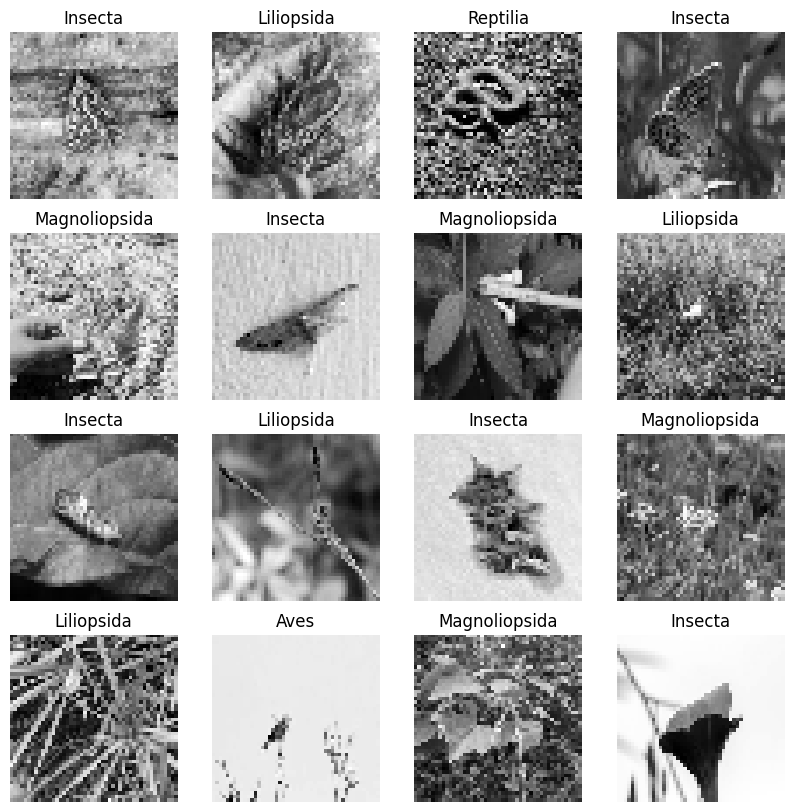

In [ ]:
plt.figure(figsize=(10, 10))

for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(X[i].reshape(48,48), cmap='gray')
  if fine_grain:
    plt.title(fine_names[Y[i]])
  else:
    plt.title(coarse_names[Y[i]])
  plt.axis("off")
plt.show();

### Create datasets for Deep Learning

In [ ]:
train_ds = create_dataset_tf('train', fine_grained=fine_grain, batch_size=1000)
val_ds = create_dataset_tf('val', fine_grained=fine_grain, batch_size=1000)
test_ds = create_dataset_tf('test', fine_grained=fine_grain, batch_size=1000)

In [ ]:
percent = 0.2
partial_train_ds = train_ds.take(int(len(train_ds) * percent))
partial_val_ds = val_ds.take(int(len(val_ds) * percent))

In [ ]:
print("Training Images: ", len(partial_train_ds) * 1000)
print("Testing Images: ", len(test_ds) * 1000)
print("Validation Images: ", len(partial_val_ds) * 1000)

Training Images:  20000
Testing Images:  50000
Validation Images:  10000


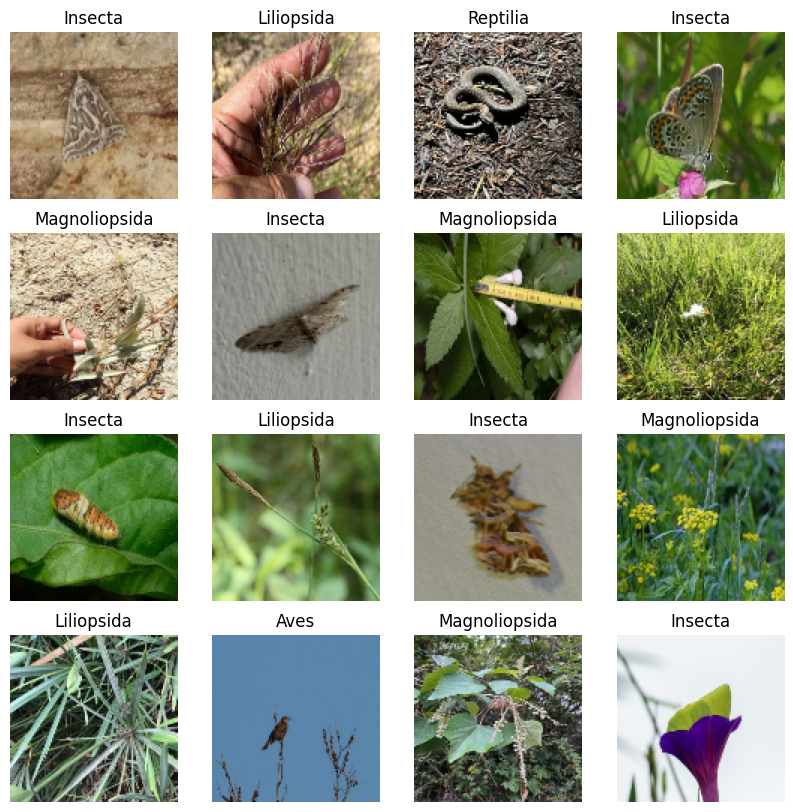

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in partial_train_ds.take(1):
  
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy())
    if fine_grain:
      plt.title(fine_names[labels[i]])
    else:
      plt.title(coarse_names[labels[i]])
    plt.axis("off")
plt.show();

# Conventional ML Model

The final model that produced the best-performing predictions for the Kaggle submission (accuracy x%) was an SVM with a polynomial kernel.  The features were ...

In [ ]:
# some initialisation code

The code below handles feature extraction by first preprocessing the text, and then ...

In [ ]:
# preprocessing + feature extraction code

The model is defined ...

In [ ]:
# model definition code

# Notes on the Conventional ML Model

For the final model, hyperparameters were chosen by ...

In addition to the final model, I also tried a logistic regression model, ...  This performed fairly poorly (accuracy y%) ...  This may have been because ...

# Deep Learning Model

The final model that produced the best-performing predictions for the Kaggle submission (accuracy (x+5)%) was a fully connected dense model with NN layers.  The input was the raw data that had been preprocessed by ...

[Following this, code and comments as above.]

# Notes on the Deep Learning Model

For the final model, hyperparameters were chosen by ...

In addition to the final model, I also tried a CNN with two conv layers and ...  This performed almost as well as the final model (accuracy (x-3)%) ...  This gap in performance may have been because ...

# Discussion of Model Performance and Implementation

Comparing my final conventional ML and deep learning models, the deep learning one performed better by 5% on the public test set.  The deep learning model ranked #12 out of N submissions on the public test set, with the top-performing system having z% accuracy, and a majority class baseline having z'% accuracy ...

[E.g. discussion about what performance on validation set versus public test set might say about your models or about the dataset.]

[E.g. discussion about what performance on private test set versus public test set might say about your models or about the dataset.]

[E.g. discussion about what inspecting the data might say about your models or about the dataset.]

[E.g. reflection on resource required for models or other implementation issues.]

